# **Dataset for Conditional Quantile Regression**

The dataset is designed for evaluating **Conditional Quantile Regression** models. It consists of a two-dimensional output variable $Y = [y_0, y_1]$ that is conditioned on a **scalar input variable** $X$.

<div align="center">
    <img src="./images/uc_marginal.png" alt="Marginal Distributions" height="300"/>
</div>

The objective is to learn the conditional distributions $P(Y \mid X = x)$ and estimate conditional quantiles for various confidence intervals and conditioning values.

A **confidence interval (CI)** is a region where the true value of $Y$ is expected to lie with a given probability $1 - \alpha$. For example, a **95% confidence interval** corresponds to $1 - \alpha = 0.95$. The qu quantiles defining the CI boundaries are:
  - Lower bound: $\alpha / 2$
  - Upper bound: $1 - \alpha / 2$

These quantile change given different conditioning values $P(Y \mid X = x'|)$, and our goal is to learn to predict/regress them
<div align="center">
    <img src="./images/uc_conditional.png" alt="Conditional" height="300"/>
</div>

---

### **Data Generation Process**

_This experiment was originally proposed in "[Calibrated Multiple-Output Quantile Regression with Representation Learning](https://arxiv.org/abs/2110.00816)" by Shai Feldman, Stephen Bates, Yaniv Romano_
- **Input Variable**: $X \in \mathbb{R}$, sampled uniformly from the interval $[-4.0, 0.8] \cup [0.8, 4.0]$.

- **Output Variable**: $Y = [y_0, y_1] \in \mathbb{R}^2$, generated according to the following equations:

  $$
  y_0 = \frac{z}{\beta |X|} + r \cos(\phi)
  $$

  $$
  y_1 = 0.5 \left( -\cos(z) + 1 \right) + r \sin(\phi) + \sin(|X|)
  $$

  Where:
  - $z \sim \text{Uniform}(-\pi, \pi)$
  - $\phi \sim \text{Uniform}(0, 2\pi)$
  - $r \sim \text{Uniform}(-0.1, 0.1)$
  - $\beta$ is a randomly sampled coefficient normalized to sum to $1$.

---

In [2]:
%load_ext autoreload
%autoreload 2

import math
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from symm_learning.models import MLP
from torch.nn import BatchNorm1d, Linear, Sequential
from torch.utils.data import DataLoader, TensorDataset

from symm_rep_learn.inference import NCPConditionalCDF

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.parent != PROJECT_ROOT and not (PROJECT_ROOT / '.git').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from paper.examples.utils import (
    LiveLossPlotter,
    dataframe_to_markdown,
    log_metrics,
    plot_sample_efficiency,
)
from paper.examples.conditional_quantile_regression.plotting import (
    plot_basis_functions_x,
    plot_basis_functions_y,
    plot_ccdf_diagnostics,
    plot_conditional_samples,
    plot_marginal_summary,
    plot_model_quantile_prediction,
    plot_quantile_comparison_grid,
    plot_quantiles,
)

plt.style.use('seaborn-v0_8-notebook')

EXPERIMENT_ROOT = Path.cwd().resolve()
PLOT_PATH = EXPERIMENT_ROOT / 'plots'
CHECKPOINT_PATH = EXPERIMENT_ROOT / 'checkpoints'
METRICS_PATH = CHECKPOINT_PATH / 'metrics'
for path in (PLOT_PATH, CHECKPOINT_PATH, METRICS_PATH):
    path.mkdir(parents=True, exist_ok=True)

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

SAMPLE_SIZE = 20000
BATCH_SIZE = 1024
EPOCHS = 500
VALIDATE_EVERY = 10
PLOT_FREQ = 10
TRAIN_SPLIT = 0.384
CAL_SPLIT = 0.256
VAL_SPLIT = 0.160
TEST_SPLIT = 0.200

ALPHA = 0.05
ORTH_REG = 2.5
LR = 5e-4
EMBEDDING_DIM = 16
SUPPORT_POINTS = 100
METRICS_PREFIX = 'cqr_metrics'

FIG_SIZE = (4, 3)
X_MIN, X_MAX = 0.8, 4

torch.manual_seed(SEED)
np.random.seed(SEED)


def synthetic_dataset(n: int, p: int = 1, condition_on_x: torch.Tensor | None = None):
    """Synthetic dataset from https://arxiv.org/abs/2110.00816, Appendix B.1."""

    beta_hat = torch.rand(size=(n, p))
    beta = beta_hat / torch.linalg.norm(beta_hat, ord=1, dim=1, keepdim=True)
    z = 2 * torch.pi * torch.rand(size=(n, p)) - torch.pi
    phi = 2 * torch.pi * torch.rand(size=(n, p))
    r = 2 * 0.1 * torch.rand(size=(n, p)) - 0.1
    if condition_on_x is None:
        x = torch.rand(size=(n, p)) * (X_MAX - X_MIN) + X_MIN
        x = torch.where(torch.rand(size=(n, p)) < 0.5, x, -x)
    else:
        x = condition_on_x
    denom = (beta * torch.abs(x)).sum(dim=1, keepdim=True)
    y_0 = z / denom + r * torch.cos(phi)
    y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(torch.abs(x)).mean(dim=1, keepdim=True)
    return x, y_0, y_1


def conditional_numpy_samples(x_value: float, n: int = SAMPLE_SIZE) -> np.ndarray:
    """Utility to sample y|x as a NumPy array."""

    x_tensor = torch.tensor([x_value], dtype=torch.float32).reshape(1, 1)
    _, y0, y1 = synthetic_dataset(n=n, p=1, condition_on_x=x_tensor)
    return np.hstack([y0.cpu().numpy(), y1.cpu().numpy()])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


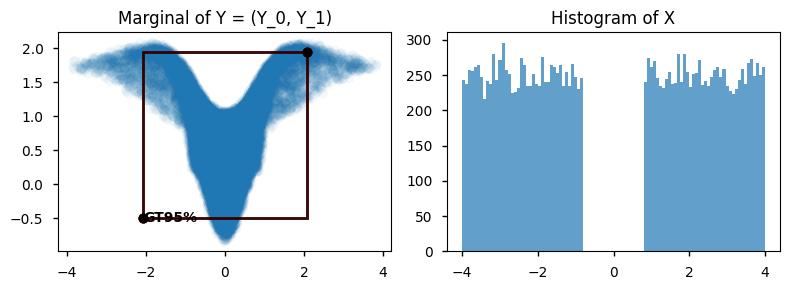

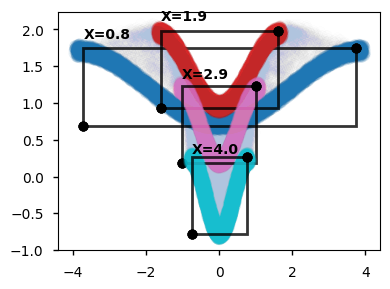

In [3]:
# Visualise marginal and conditional distributions of the synthetic dataset
x_full, y0_full, y1_full = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y_full = torch.hstack([y0_full, y1_full]).cpu().numpy()
x_full_np = x_full.cpu().numpy()

fig_marginal, _ = plot_marginal_summary(
    y_samples=y_full,
    x_samples=x_full_np,
    alpha=ALPHA,
    fig_size=FIG_SIZE,
    output_path=PLOT_PATH / 'uc_marginal.png',
)

x_cond_vals = np.linspace(float(np.abs(x_full_np).min()), float(np.abs(x_full_np).max()), 4)
fig_conditional, _ = plot_conditional_samples(
    dataset_fn=lambda value: conditional_numpy_samples(value, n=SAMPLE_SIZE),
    x_values=x_cond_vals,
    alpha=ALPHA,
    base_samples=y_full,
    fig_size=FIG_SIZE,
    output_path=PLOT_PATH / 'uc_conditional.png',
)

y_background = y_full


# Experiment configuration

In [4]:
# Dataset preparation
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y = torch.hstack([y_0, y_1])

ntrain = int(TRAIN_SPLIT * SAMPLE_SIZE)
ncal = int(CAL_SPLIT * SAMPLE_SIZE)
nval = int(VAL_SPLIT * SAMPLE_SIZE)
ntest = SAMPLE_SIZE - (ntrain + ncal + nval)

x_train_mlp, y_train_mlp = x[:ntrain], y[:ntrain]
x_cal, y_cal = x[ntrain : ntrain + ncal], y[ntrain : ntrain + ncal]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval], y[ntrain + ncal : ntrain + ncal + nval]
x_test, y_test = x[ntrain + ncal + nval :], y[ntrain + ncal + nval :]

x_train = torch.vstack([x_train_mlp, x_cal])
y_train = torch.vstack([y_train_mlp, y_cal])
print(
    f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}"
)

x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)
x_train_std = x_train.std(dim=0) + 1e-8
y_train_std = y_train.std(dim=0) + 1e-8

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
x_train_mlp = (x_train_mlp - x_train_mean) / x_train_std
y_train_mlp = (y_train_mlp - y_train_mean) / y_train_std
x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std
x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std
x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

train_ds = TensorDataset(x_train, y_train)
train_mlp_ds = TensorDataset(x_train_mlp, y_train_mlp)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
train_dl_mlp = DataLoader(train_mlp_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)


Sanity check: train=12800, cal=5120, val=3200, test=4000


# Training data-driven models
## **Multivariate Conformalized Quantile Regression (CQR)**

Multivariate Conformalized Quantile Regression (CQR) is a neural network-based approach, typically employing a Multilayer Perceptron (MLP), to estimate conditional quantiles of a multivariate random variable $Y \in \mathbb{R}^d$ given $X \in \mathbb{R}^p$.

The model is trained to predict specific quantiles corresponding to pre-defined confidence levels (e.g., 0.1, 0.5, 0.9) for a desired coverage probability $1 - \alpha$. During training, the MLP learns mappings from $X$ to the desired quantiles of $Y$.


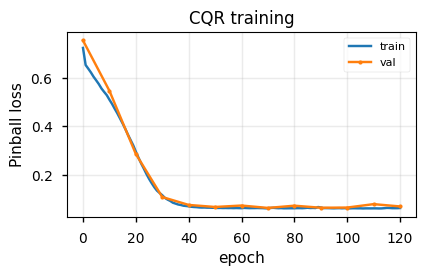

Early stopping at epoch 120


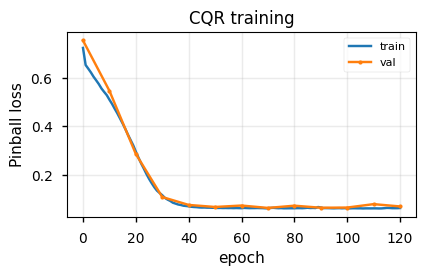

Saved CQR checkpoint to /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_quantile_regression/checkpoints/cqr_mlp_N=20000_seed=42.pt
Best validation pinball loss: 0.0626


In [5]:
import copy


def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss to learn (gamma/2)-quantiles."""

    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 64,
    n_hidden_layers: int = 3,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden_layers - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim)]
    return Sequential(*layers)


lower_quantile_estimator = make_mlp().to(DEVICE)
upper_quantile_estimator = make_mlp().to(DEVICE)
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters(), lr=LR)
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters(), lr=LR)


def train_epoch(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
) -> float:
    lo_q_est.train()
    up_q_est.train()
    total_loss = 0.0

    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

        opt_lo.zero_grad()
        opt_up.zero_grad()

        q_lo = lo_q_est(x_batch)
        q_up = up_q_est(x_batch)

        loss_lo = pinball_loss(input=q_lo, target=y_batch, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y_batch, gamma=1 - (ALPHA / 2))
        loss = loss_lo + loss_up

        loss.backward()
        opt_lo.step()
        opt_up.step()

        total_loss += loss.item()

    return total_loss / max(len(train_dl), 1)


@torch.no_grad()
def validate(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, val_dl: DataLoader) -> float:
    lo_q_est.eval()
    up_q_est.eval()
    total_loss = 0.0

    for x_batch, y_batch in val_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        q_lo = lo_q_est(x_batch)
        q_up = up_q_est(x_batch)

        loss_lo = pinball_loss(input=q_lo, target=y_batch, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y_batch, gamma=1 - (ALPHA / 2))
        total_loss += (loss_lo + loss_up).item()

    return total_loss / max(len(val_dl), 1)


CQR_CHECKPOINT = CHECKPOINT_PATH / f'cqr_mlp_N={SAMPLE_SIZE}_seed={SEED}.pt'
if CQR_CHECKPOINT.exists():
    state = torch.load(CQR_CHECKPOINT, map_location=DEVICE)
    lower_quantile_estimator.load_state_dict(state['lower'])
    upper_quantile_estimator.load_state_dict(state['upper'])
    print(f'Loaded CQR checkpoint from {CQR_CHECKPOINT}')
else:
    best_val_loss = float('inf')
    best_states: dict[str, dict] | None = None
    patience_counter = 0
    PATIENCE = 5
    plotter = LiveLossPlotter(title='CQR training', ylabel='Pinball loss', plot_freq=PLOT_FREQ)

    for epoch in range(EPOCHS):
        train_loss = train_epoch(
            lo_q_est=lower_quantile_estimator,
            up_q_est=upper_quantile_estimator,
            train_dl=train_dl_mlp,
            opt_lo=opt_lo,
            opt_up=opt_up,
        )

        val_loss = None
        if epoch % VALIDATE_EVERY == 0 or epoch == EPOCHS - 1:
            val_loss = validate(
                lo_q_est=lower_quantile_estimator,
                up_q_est=upper_quantile_estimator,
                val_dl=val_dl,
            )

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_states = {
                    'lower': copy.deepcopy(lower_quantile_estimator.state_dict()),
                    'upper': copy.deepcopy(upper_quantile_estimator.state_dict()),
                }
            else:
                patience_counter += 1

        plotter.update(epoch, train_loss=train_loss, val_loss=val_loss)

        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

    plotter.close()

    if best_states is not None:
        torch.save(best_states, CQR_CHECKPOINT)
        lower_quantile_estimator.load_state_dict(best_states['lower'])
        upper_quantile_estimator.load_state_dict(best_states['upper'])
        print(f'Saved CQR checkpoint to {CQR_CHECKPOINT}')

lower_quantile_estimator.eval()
upper_quantile_estimator.eval()
print(f'Best validation pinball loss: {validate(lower_quantile_estimator, upper_quantile_estimator, val_dl):.4f}')


### Example use of CQR

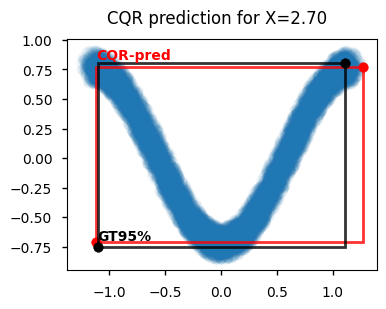

In [6]:
# Quantile regression prediction using the MLP baseline
X_COND = 2.7
x_cond_tensor = torch.tensor([X_COND], dtype=torch.float32).reshape(1, 1)
x_cond, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=x_cond_tensor)
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x_cond - x_train_mean) / x_train_std

low_q = torch.squeeze(lower_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()
up_q = torch.squeeze(upper_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()

fig_cqr, _ = plot_model_quantile_prediction(
    y_cond=y_c.cpu().numpy(),
    q_lo=low_q,
    q_up=up_q,
    x_value=X_COND,
    alpha=ALPHA,
    label='CQR',
    fig_size=FIG_SIZE,
    output_path=PLOT_PATH / f'cqr_prediction_x_{X_COND:.2f}.png',
)


## **Neural Conditional Probability** (NCP)


Neural Conditional Probability (NCP) is a representation learning algorithm designed for various inference tasks, including quantile regression. It learns non-linear transformations of the random variables $X$ and $Y$ by approximating the **conditional expectation operator**.

---

### **Marginal Cumulative Distribution Function (CDF)**
The marginal CDF of a random variable $Y \in \mathbb{R}^d$ is defined as:

$$
F_Y(y) = \mathbb{P}(Y \leq y)
$$

This function provides the probability that $Y$ takes values less than or equal to $y$ in the marginal (unconditioned) case.

---

### **Conditional Cumulative Distribution Function (CondCDF)**
The Conditional CDF (CondCDF) for a given $X = x$ is defined as:

$$
F_{Y \mid X}(y \mid x) = \mathbb{P}(Y \leq y \mid X = x)
$$

This function describes the probability that $Y$ takes values less than or equal to $y$, conditioned on a specific value of $X = x$.

---

### **Approach**
NCP approximates the **conditional expectation operator** $\mathbb{E}[Y \mid X = x]$, allowing the model to simultaneously learn data representations for $X$ and $Y$. Using these representations, the model regresses the CondCDF by learning how to deform the **marginal CDF** $F_Y(y)$ to obtain the corresponding **CondCDF** $F_{Y \mid X}(y \mid x)$ for each conditioning value $x$.

Essentially, the model captures how the distribution of $Y$ changes in response to changes in $X$, enabling effective quantile regression and other uncertainty quantification tasks.


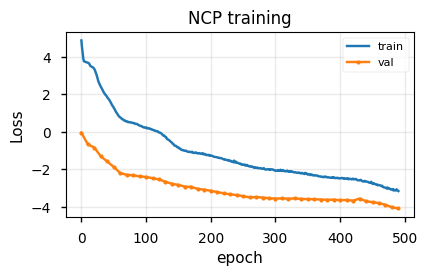

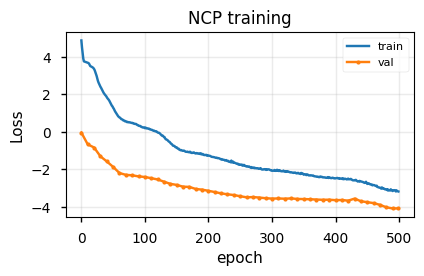

Saved NCP checkpoint to /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_quantile_regression/checkpoints/ncp_N=20000_seed=42.pt
NCP validation ||k(x,y) - k_r(x,y)||: -4.0889


In [7]:
from symm_rep_learn.models import NCP

ncp = NCP(
    embedding_x=MLP(
        in_dim=1,
        out_dim=EMBEDDING_DIM,
        hidden_units=[64] * 3,
        activation=torch.nn.ELU(),
        bias=True,
    ),
    embedding_y=MLP(
        in_dim=2,
        out_dim=EMBEDDING_DIM,
        hidden_units=[64] * 3,
        activation=torch.nn.ELU(),
        bias=True,
    ),
    embedding_dim_x=EMBEDDING_DIM,
    embedding_dim_y=EMBEDDING_DIM,
    orth_reg=ORTH_REG,
).to(DEVICE)

ncp_optimizer = torch.optim.Adam(ncp.parameters(), lr=LR)


@torch.no_grad()
def validate_ncp(model: torch.nn.Module, val_dl: DataLoader) -> float:
    model.eval()
    total_metric = 0.0

    for x_batch, y_batch in val_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        fx, hy = model(x_batch, y_batch)
        _, metrics = model.loss(fx, hy)
        total_metric += float(metrics["||k(x,y) - k_r(x,y)||"])

    return total_metric / max(len(val_dl), 1)


def train_ncp_epoch(model: torch.nn.Module, train_dl: DataLoader, optimizer: torch.optim.Optimizer) -> tuple[float, float]:
    model.train()
    total_loss = 0.0
    total_metric = 0.0

    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        fx, hy = model(x_batch, y_batch)
        loss, metrics = model.loss(fx, hy)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        total_metric += float(metrics["||k(x,y) - k_r(x,y)||"])

    n_batches = max(len(train_dl), 1)
    return total_loss / n_batches, total_metric / n_batches


NCP_CHECKPOINT = CHECKPOINT_PATH / f'ncp_N={SAMPLE_SIZE}_seed={SEED}.pt'
if NCP_CHECKPOINT.exists():
    state = torch.load(NCP_CHECKPOINT, map_location=DEVICE)
    ncp.load_state_dict(state)
    print(f'Loaded NCP checkpoint from {NCP_CHECKPOINT}')
else:
    best_val_metric = float('inf')
    best_state = None
    patience_counter = 0
    PATIENCE = 5

    plotter = LiveLossPlotter(title='NCP training', ylabel='Loss', plot_freq=PLOT_FREQ)

    for epoch in range(EPOCHS):
        train_loss, train_metric = train_ncp_epoch(ncp, train_dl, ncp_optimizer)
        val_metric = None

        if epoch % VALIDATE_EVERY == 0 or epoch == EPOCHS - 1:
            val_metric = validate_ncp(ncp, val_dl)
            if val_metric < best_val_metric:
                best_val_metric = val_metric
                best_state = {k: v.cpu() for k, v in ncp.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1

        plotter.update(epoch, train_loss=train_loss, val_loss=val_metric)

        if patience_counter >= PATIENCE:
            print(f'Early stopping NCP at epoch {epoch}')
            break

    plotter.close()

    if best_state is not None:
        ncp.load_state_dict(best_state)
        torch.save(best_state, NCP_CHECKPOINT)
        print(f'Saved NCP checkpoint to {NCP_CHECKPOINT}')

best_ncp_val_metric = validate_ncp(ncp, val_dl)
print(f'NCP validation ||k(x,y) - k_r(x,y)||: {best_ncp_val_metric:.4f}')


In [8]:
# NCP conditional CDF helper
ncp_ccdf = NCPConditionalCDF(
    model=ncp,
    y_train=y_train,
    support_discretization_points=SUPPORT_POINTS,
    ridge_reg=1e-3,
)


@torch.no_grad()
def test_ncp_uc(model: NCPConditionalCDF, test_dl: DataLoader):
    coverage = 0.0
    set_size = 0.0
    model.eval()

    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        q_lo, q_up = model.conditional_quantiles(x_cond=x_batch, alpha=ALPHA)
        q_lo = torch.as_tensor(q_lo, dtype=torch.float32, device=DEVICE)
        q_up = torch.as_tensor(q_up, dtype=torch.float32, device=DEVICE)
        coverage += ((q_lo <= y_batch) & (y_batch <= q_up)).all(dim=1, keepdim=True).float().mean().item()
        set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean().item()

    n_batches = max(len(test_dl), 1)
    return coverage / n_batches, set_size / n_batches


coverage_ncp, set_size_ncp = test_ncp_uc(model=ncp_ccdf, test_dl=test_dl)


### **Visualizing Learned Data Representations (Basis Functions)**

In this section, we visualize the **basis functions** learned by the model as part of the non-linear transformations applied to the random variables $X$ and $Y$. These functions approximate an orthonormal basis set capable of representing a broad class of functions in the spaces $L^2_{P_X}$ and $L^2_{P_Y}$.

A crucial characteristic of these basis sets is that they enable the computation of the **conditional expectation** of any observable $\psi(y)$ belonging to the basis set. Specifically, we can compute:

$$
\mathbb{E}_{Y \mid X = x} \left[ \psi(Y) \mid X = x \right]
$$

using the learned data representations and the approximated **conditional expectation operator**.

This property is particularly powerful because, if we regress the **CondCDF** in terms of all basis functions $\{ \psi_i \}$, we can effectively compute the conditioning of the CondCDF for every $X$ in the training distribution of the NCP model. By leveraging the learned basis set, the model provides a flexible and efficient mechanism for capturing conditional dependencies across a wide range of observables.


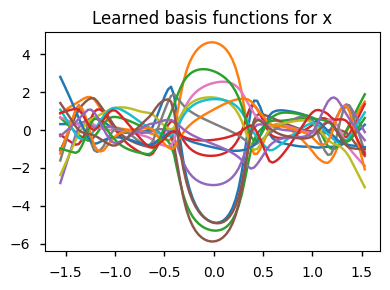

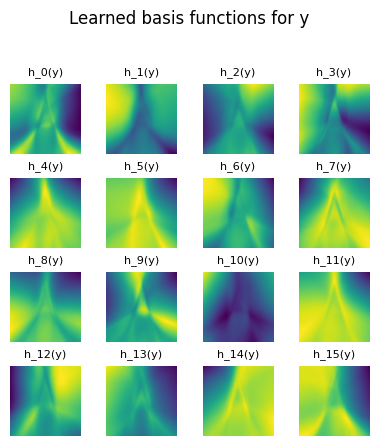

In [32]:
# Visualise learned basis functions (NCP)
x_range = torch.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    fx, _ = ncp(x=x_range)

plot_basis_functions_x(
    x_grid=x_range.cpu().numpy(),
    fx=fx.cpu().numpy(),
    fig_size=FIG_SIZE,
    output_path=PLOT_PATH / 'ncp_x_basis_functions.png',
)

N_GRID_POINTS = 100
y0_range = np.linspace(y_train[:, 0].min().item(), y_train[:, 0].max().item(), N_GRID_POINTS)
y1_range = np.linspace(y_train[:, 1].min().item(), y_train[:, 1].max().item(), N_GRID_POINTS)
y0_grid, y1_grid = np.meshgrid(y0_range, y1_range)
y_grid = torch.tensor(np.vstack([y0_grid.ravel(), y1_grid.ravel()]).T, device=DEVICE, dtype=torch.float32)

with torch.no_grad():
    _, hy = ncp(y=y_grid)
    hy = hy.reshape(N_GRID_POINTS, N_GRID_POINTS, EMBEDDING_DIM).cpu().numpy()

fig = plot_basis_functions_y(
    hy_images=hy,
    ncols=4,
    fig_size=(FIG_SIZE[0] * 1, FIG_SIZE[1] * 1.5),
    suptitle='Learned basis functions for y',
    output_path=PLOT_PATH / 'ncp_y_basis_functions.png',
)


### **NCP Regression of the Conditional CDF (CondCDF)**

In this cell, we demonstrate how to **regress the CondCDF** using the learned basis functions and the approximated conditional expectation operator. This approach enables us to compute the CondCDF for any input $X = x$ and use it to derive predicted quantiles for arbitrary confidence interval probabilities.

---

#### **Why Regress the CondCDF?**
The **CondCDF** is a fundamental object in probabilistic regression and uncertainty quantification. By approximating the CondCDF, we can compute quantiles for **any desired confidence level** without retraining the model. Unlike standard quantile regression methods that require retraining for different probabilities, the NCP model learns the entire distribution through the operator approximation.

---

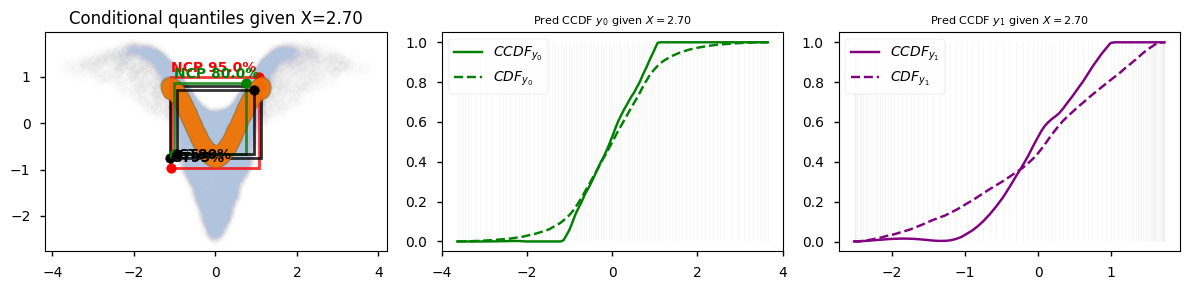

In [11]:
# NCP CCDF diagnostics at a fixed conditioning value
x_cond_tensor = torch.tensor([X_COND], dtype=torch.float32).reshape(1, 1)
x_cond, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=x_cond_tensor)
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x_cond - x_train_mean) / x_train_std

ccdf = ncp_ccdf(x_cond=x_c)
fig_ncp_ccdf, axs = plot_ccdf_diagnostics(
    support=ncp_ccdf.discretized_support,
    ccdf=ccdf,
    marginal_cdf=ncp_ccdf.marginal_CDF,
    x_value=X_COND,
    fig_size=(FIG_SIZE[0] * 3, FIG_SIZE[1]),
)

ax_quant = axs[0]
ax_quant.cla()
ax_quant.scatter(y_train[:, 0].cpu(), y_train[:, 1].cpu(), alpha=0.01, color='lightsteelblue')
for alpha, color in zip([0.05, 0.2], ['red', 'green']):
    q_low, q_high = ncp_ccdf.conditional_quantiles(x_cond=x_c, alpha=alpha)
    plot_quantiles(
        y_c.cpu().numpy(),
        q_low,
        q_high,
        label=f'NCP {(1 - alpha) * 100:.1f}%',
        alpha=alpha,
        ax=ax_quant,
        quantile_color=color,
    )
ax_quant.set_title(rf'Conditional quantiles given X={X_COND:.2f}')

fig_ncp_ccdf.tight_layout()
fig_ncp_ccdf.savefig(PLOT_PATH / 'ncp_ccdf_regression.png', dpi=250)


## **Training E-NCP Model (Our Model)**

The **E-NCP model** is an extension of the **Neural Conditional Probability (NCP)** approach designed to leverage the inherent **symmetries** present in the data distributions of $X$ and $Y$. By incorporating these symmetries explicitly, the E-NCP model improves the efficiency and robustness of the learning process.

---

### **Symmetries in the Data Distribution**

In our setting, the data distributions of $X$ and $Y$ exhibit specific symmetries related to the **reflection symmetry group**:

- **Reflection Symmetry Group** $\mathbb{G} = \mathbb{C}_2 = \{e, g_r \mid g_r^2 = e\}$

- **Symmetries of $X$ (Inputs):**
  - $P(X) = P(g_r X) = P(X)$
  - This implies that applying the reflection transformation $g_r$ to $X$ leaves the distribution invariant.

- **Symmetries of $Y$ (Outputs):**
  - For $Y = (y_0, y_1)$, the symmetries are:
    - $P(y_0) = P(g_r y_0) = P(-y_0)$ (reflection symmetry along the $y_0$ axis)
    - $P(y_1) = P(g_r y_1) = P(y_1)$ (invariant under reflection)

---

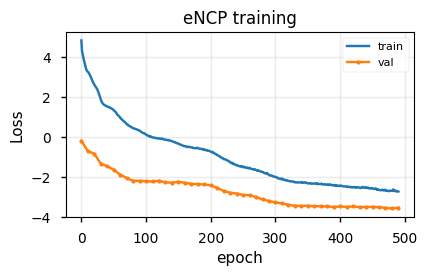

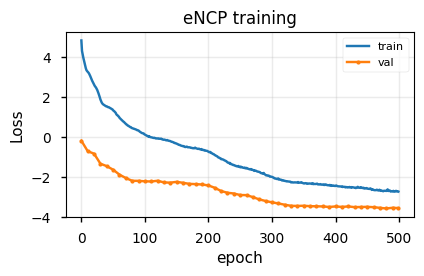

Saved ENCP checkpoint to /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_quantile_regression/checkpoints/encp_N=20000_seed=42.pt
eNCP validation ||k(x,y) - k_r(x,y)||: -3.5845


In [33]:
import numpy as np
from escnn.group import CyclicGroup
from escnn.gspaces import no_base_space
from escnn.nn import FieldType
from symm_learning.models import EMLP

from symm_rep_learn.inference import ENCPConditionalCDF
from symm_rep_learn.models import ENCP

G = CyclicGroup(2)
x_type = FieldType(no_base_space(G), representations=[G.representations['irrep_1']])
y_type = FieldType(no_base_space(G), representations=[G.representations['irrep_1'], G.representations['irrep_0']])
lat_type = FieldType(no_base_space(G), representations=[G.regular_representation] * int(EMBEDDING_DIM / G.order()))

encp = ENCP(
    embedding_x=EMLP(in_type=x_type, out_type=lat_type, hidden_units=[64] * 3, activation='ELU'),
    embedding_y=EMLP(in_type=y_type, out_type=lat_type, hidden_units=[64] * 3, activation='ELU'),
    orth_reg=ORTH_REG,
).to(DEVICE)

encp_optimizer = torch.optim.Adam(encp.parameters(), lr=LR)


@torch.no_grad()
def validate_encp(model: torch.nn.Module, val_dl: DataLoader) -> float:
    model.eval()
    total_metric = 0.0

    for x_batch, y_batch in val_dl:
        x_batch = x_type(x_batch).to(DEVICE)
        y_batch = y_type(y_batch).to(DEVICE)
        fx, hy = model(x_batch, y_batch)
        _, metrics = model.loss(fx, hy)
        total_metric += float(metrics['||k(x,y) - k_r(x,y)||'])

    return total_metric / max(len(val_dl), 1)


def train_encp_epoch(model: torch.nn.Module, train_dl: DataLoader, optimizer: torch.optim.Optimizer) -> tuple[float, float]:
    model.train()
    total_loss = 0.0
    total_metric = 0.0

    for x_batch, y_batch in train_dl:
        x_batch = x_type(x_batch).to(DEVICE)
        y_batch = y_type(y_batch).to(DEVICE)

        optimizer.zero_grad()
        fx, hy = model(x_batch, y_batch)
        loss, metrics = model.loss(fx, hy)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        total_metric += float(metrics['||k(x,y) - k_r(x,y)||'])

    n_batches = max(len(train_dl), 1)
    return total_loss / n_batches, total_metric / n_batches


ENCP_CHECKPOINT = CHECKPOINT_PATH / f'encp_N={SAMPLE_SIZE}_seed={SEED}.pt'
if ENCP_CHECKPOINT.exists():
    state = torch.load(ENCP_CHECKPOINT, map_location=DEVICE)
    encp.load_state_dict(state)
    print(f'Loaded ENCP checkpoint from {ENCP_CHECKPOINT}')
else:
    best_val_metric = float('inf')
    best_state = None
    patience_counter = 0
    PATIENCE = 5

    plotter = LiveLossPlotter(title='eNCP training', ylabel='Loss', plot_freq=PLOT_FREQ)

    for epoch in range(EPOCHS):
        train_loss, train_metric = train_encp_epoch(encp, train_dl, encp_optimizer)
        val_metric = None

        if epoch % VALIDATE_EVERY == 0 or epoch == EPOCHS - 1:
            val_metric = validate_encp(encp, val_dl)
            if val_metric < best_val_metric:
                best_val_metric = val_metric
                best_state = {k: v.cpu() for k, v in encp.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1

        plotter.update(epoch, train_loss=train_loss, val_loss=val_metric)

        if patience_counter >= PATIENCE:
            print(f'Early stopping eNCP at epoch {epoch}')
            break

    plotter.close()

    if best_state is not None:
        encp.load_state_dict(best_state)
        torch.save(best_state, ENCP_CHECKPOINT)
        print(f'Saved ENCP checkpoint to {ENCP_CHECKPOINT}')

encp.eval()
best_encp_val_metric = validate_encp(encp, val_dl)
print(f'eNCP validation ||k(x,y) - k_r(x,y)||: {best_encp_val_metric:.4f}')


In [34]:
# eNCP conditional CDF helper
encp.eval()
encp_ccdf = ENCPConditionalCDF(
    model=encp,
    y_train=y_type(y_train),
    support_discretization_points=SUPPORT_POINTS,
    ridge_reg=1e-3,
)


@torch.no_grad()
def test_encp_uc(model: ENCPConditionalCDF, test_dl: DataLoader):
    coverage = 0.0
    set_size = 0.0
    model.eval()

    for x_batch, y_batch in test_dl:
        x_field = x_type(x_batch).to(DEVICE)
        y_field = y_type(y_batch).to(DEVICE)
        q_lo, q_up = model.conditional_quantiles(x_cond=x_field.tensor, alpha=ALPHA)
        q_lo = torch.as_tensor(q_lo, dtype=torch.float32, device=DEVICE)
        q_up = torch.as_tensor(q_up, dtype=torch.float32, device=DEVICE)
        coverage += ((q_lo <= y_field.tensor) & (y_field.tensor <= q_up)).all(dim=1, keepdim=True).float().mean().item()
        set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean().item()

    n_batches = max(len(test_dl), 1)
    return coverage / n_batches, set_size / n_batches


coverage_encp, set_size_encp = test_encp_uc(model=encp_ccdf, test_dl=test_dl)


### **Learned Basis Functions**

The E-NCP model learns **basis functions** for the random variables $X$ and $Y$ through the approximation of the conditional expectation operator. Importantly, the symmetries in the data distributions influence the nature of these learned functions.

---

#### **Basis Functions for $X$ (Unconstrained)**

Since $X$ is **invariant** under the group action $\mathbb{G}$, the learned basis functions for $X$ are **unconstrained**. This means that the model is free to learn a rich set of representations without symmetry-based restrictions. The learned basis functions capture relevant features of $X$ for regression tasks but are not explicitly affected by the symmetries of the group $\mathbb{G}$.

$$
P(X) = P(g_r X) = P(X)
$$

---

#### **Basis Functions for $Y \in \mathbb{R}^2$ (Constrained by Symmetry)**

The variable $Y = (y_0, y_1)$ exhibits **reflection symmetry** under the group action $\mathbb{G} = \mathbb{C}_2 = \{e, g_r\}$. This group acts differently on the components $y_0$ and $y_1$:

- $y_0$: **Reflection Symmetry**, $P(y_0) = P(-y_0)$
- $y_1$: **Invariant under reflection**, $P(y_1) = P(g_r y_1) = P(y_1)$

Since the model must respect these symmetries, the **learned basis functions for $Y$** are constrained to capture these properties. Specifically:

- **For $y_0$:** The learned basis functions must be **even functions** (symmetric) under reflection $g_r$, ensuring $P(y_0) = P(-y_0)$.
- **For $y_1$:** The learned basis functions are **unaffected** by $g_r$, meaning they are invariant under the group action.

---

#### **Constraining the Model for $G$-Invariant Functions**

Since the **CondCDF** of $y_0$ and $y_1$ is a $G$-invariant function, the model is constrained to **learn only $G$-invariant functions of $Y$**. This is achieved by restricting the learned basis functions to those


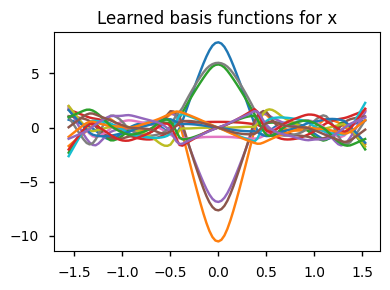

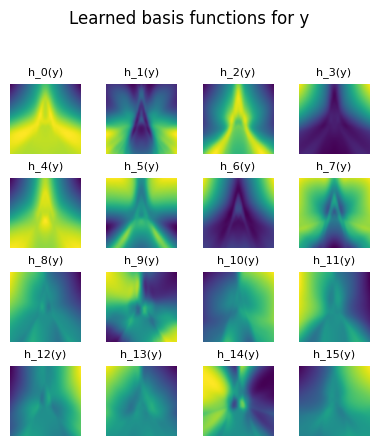

In [35]:
# Visualise learned basis functions (eNCP)
x_range = torch.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    fx, _ = encp(x_type(x_range))

plot_basis_functions_x(
    x_grid=x_range.cpu().numpy(),
    fx=fx.cpu().numpy(),
    fig_size=FIG_SIZE,
    output_path=PLOT_PATH / 'encp_x_basis_functions.png',
)

N_GRID_POINTS = 100
y0_range = np.linspace(y_train[:, 0].min().item(), y_train[:, 0].max().item(), N_GRID_POINTS)
y1_range = np.linspace(y_train[:, 1].min().item(), y_train[:, 1].max().item(), N_GRID_POINTS)
y0_grid, y1_grid = np.meshgrid(y0_range, y1_range)
y_grid = torch.tensor(np.vstack([y0_grid.ravel(), y1_grid.ravel()]).T, dtype=torch.float32)

y_field = y_type(y_grid).to(DEVICE)
with torch.no_grad():
    _, hy = encp(y=y_field)
    hy_np = hy.reshape(N_GRID_POINTS, N_GRID_POINTS, EMBEDDING_DIM).cpu().numpy()

fig = plot_basis_functions_y(
    hy_images=hy_np,
    ncols=4,
    fig_size=(FIG_SIZE[0] * 1, FIG_SIZE[1] * 1.5),
    suptitle='Learned basis functions for y',
    output_path=PLOT_PATH / 'encp_y_basis_functions.png',
)


## Use E-NCP for G-equivariant quantile regression

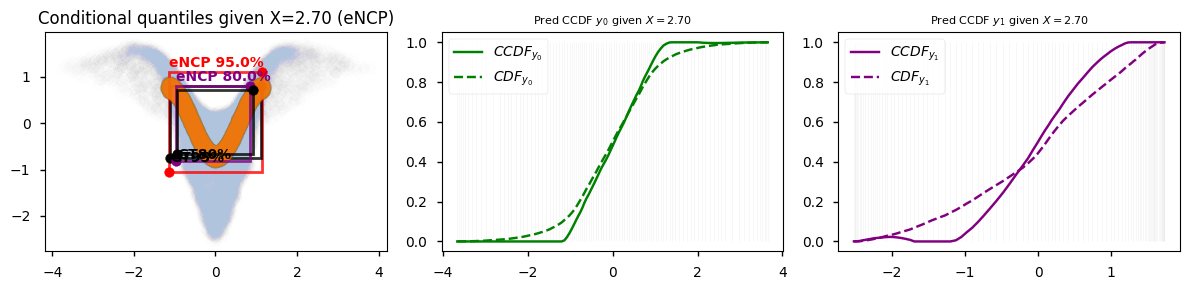

In [36]:
# eNCP CCDF diagnostics at the same conditioning value
x_cond_tensor = torch.tensor([X_COND], dtype=torch.float32).reshape(1, 1)
x_cond, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=x_cond_tensor)
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x_cond - x_train_mean) / x_train_std

ccdf_encp = encp_ccdf(x_cond=x_c.to(DEVICE))
fig_encp_ccdf, axs = plot_ccdf_diagnostics(
    support=encp_ccdf.discretized_support,
    ccdf=ccdf_encp,
    marginal_cdf=encp_ccdf.marginal_CDF,
    x_value=X_COND,
    fig_size=(FIG_SIZE[0] * 3, FIG_SIZE[1]),
)

ax_quant = axs[0]
ax_quant.cla()
ax_quant.scatter(y_train[:, 0].cpu(), y_train[:, 1].cpu(), alpha=0.01, color='lightsteelblue')
for alpha, color in zip([0.05, 0.2], ['red', 'purple']):
    q_low, q_high = encp_ccdf.conditional_quantiles(x_cond=x_c.to(DEVICE), alpha=alpha)
    plot_quantiles(
        y_c.cpu().numpy(),
        q_low,
        q_high,
        label=f'eNCP {(1 - alpha) * 100:.1f}%',
        alpha=alpha,
        ax=ax_quant,
        quantile_color=color,
    )
ax_quant.set_title(rf'Conditional quantiles given X={X_COND:.2f} (eNCP)')

fig_encp_ccdf.tight_layout()
fig_encp_ccdf.savefig(PLOT_PATH / 'encp_ccdf_regression.png', dpi=250)


# Comparison: CQR vs NCP vs eNCP
## Qualitative results

To compare all three methods for uncertainty estimation we first visualize the prediction intervals for different conditioning values of $x$.

In the second and third row you will see the predicted Conditional Cumulative Distribution Function (CondCDF) used the `eNCP` an and `NCP` models to estimate the desired quantiles. Both methods learn to approximate the deformation of the marginal CDF given different conditioning values.


/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_quantile_regression/plotting.py:320: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i, 0].legend()


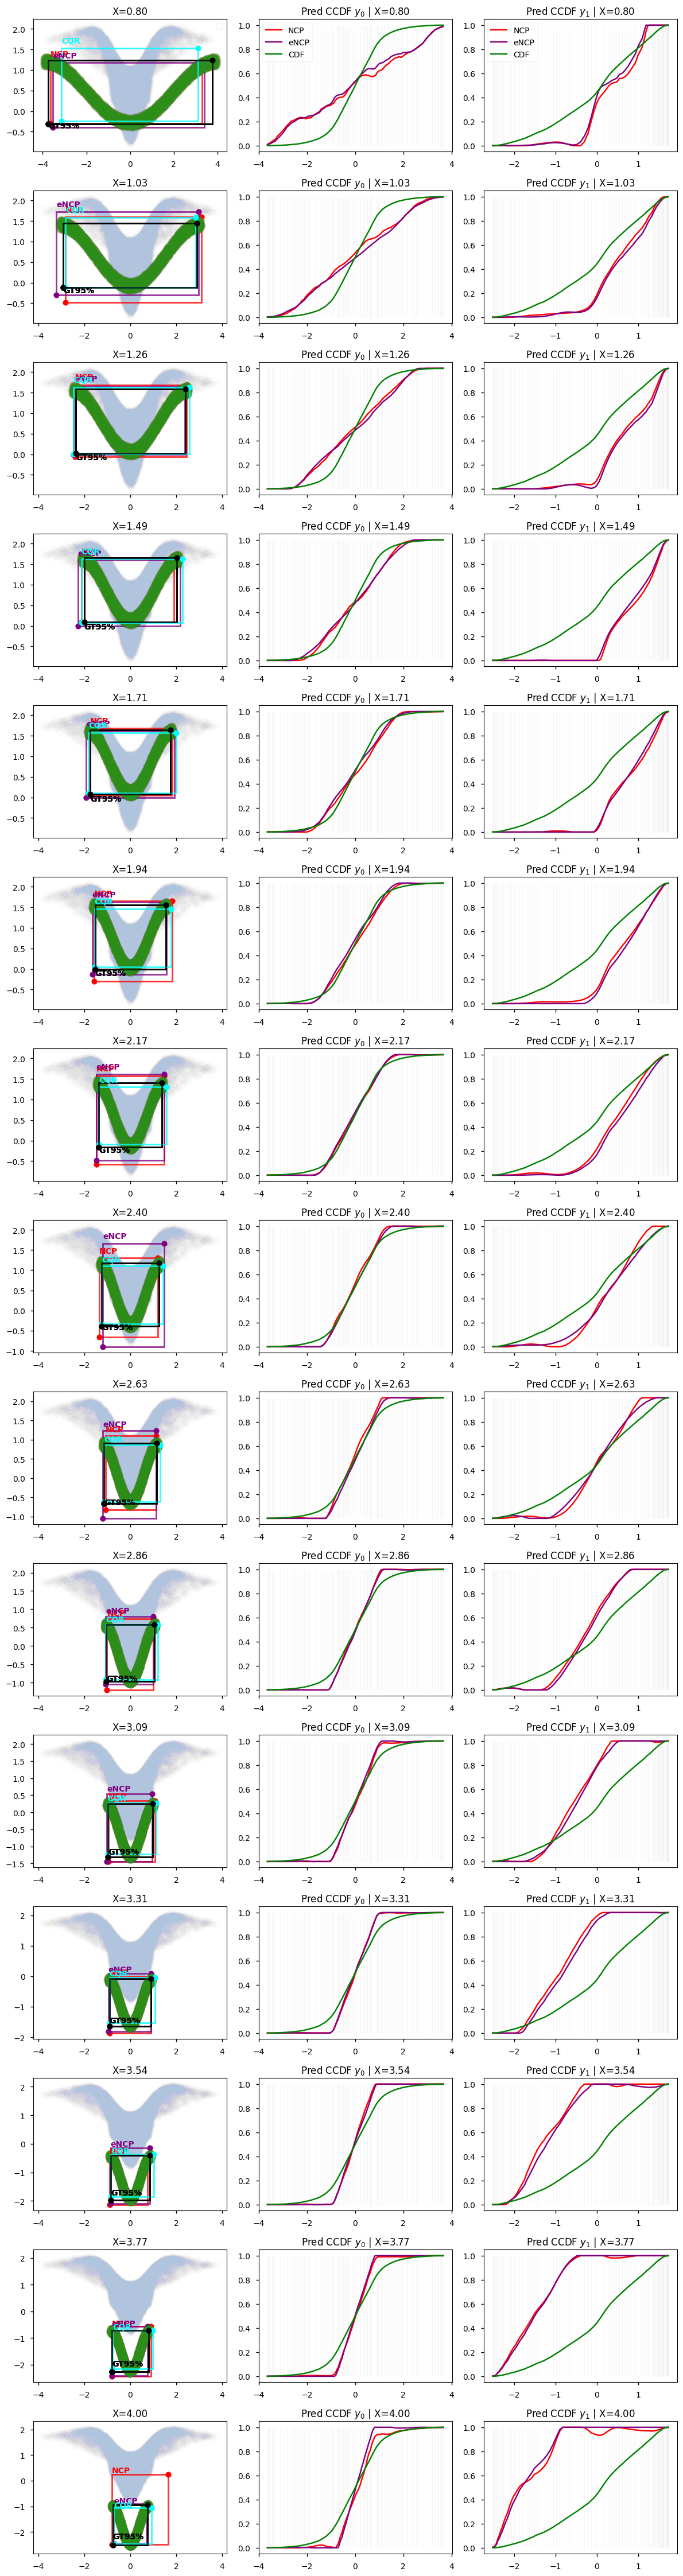

In [37]:
# Quantile comparison across conditioning values
N_COND_POINTS = 15
x_eval_grid = torch.linspace(X_MIN, X_MAX, N_COND_POINTS).tolist()


def y_samples_standardized(x_value: float) -> np.ndarray:
    x_tensor = torch.tensor([x_value], dtype=torch.float32).reshape(1, 1)
    _, y0, y1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=x_tensor)
    y = torch.hstack([y0, y1])
    y_c = (y - y_train_mean) / y_train_std
    return y_c.cpu().numpy()


def predictor_ncp(x_value: float):
    x_tensor = torch.tensor([[x_value]], dtype=torch.float32)
    x_c = (x_tensor - x_train_mean) / x_train_std
    q_lo, q_up = ncp_ccdf.conditional_quantiles(x_cond=x_c.to(DEVICE), alpha=ALPHA)
    return np.asarray(q_lo), np.asarray(q_up), 'red'


def predictor_encp(x_value: float):
    x_tensor = torch.tensor([[x_value]], dtype=torch.float32)
    x_c = (x_tensor - x_train_mean) / x_train_std
    q_lo, q_up = encp_ccdf.conditional_quantiles(x_cond=x_c.to(DEVICE), alpha=ALPHA)
    return np.asarray(q_lo), np.asarray(q_up), 'purple'


def predictor_cqr(x_value: float):
    x_tensor = torch.tensor([[x_value]], dtype=torch.float32)
    x_c = (x_tensor - x_train_mean) / x_train_std
    q_lo = torch.squeeze(lower_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()
    q_up = torch.squeeze(upper_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()
    return q_lo, q_up, 'aqua'


def ccdf_ncp(x_value: float):
    x_tensor = torch.tensor([[x_value]], dtype=torch.float32)
    x_c = (x_tensor - x_train_mean) / x_train_std
    return np.asarray(ncp_ccdf(x_cond=x_c.to(DEVICE)))


def ccdf_encp(x_value: float):
    x_tensor = torch.tensor([[x_value]], dtype=torch.float32)
    x_c = (x_tensor - x_train_mean) / x_train_std
    return np.asarray(encp_ccdf(x_cond=x_c.to(DEVICE)))

fig_grid, axs_grid = plot_quantile_comparison_grid(
    x_values=x_eval_grid,
    y_samples_fn=y_samples_standardized,
    predictors={
        'NCP': predictor_ncp,
        'eNCP': predictor_encp,
        'CQR': predictor_cqr,
    },
    alpha=ALPHA,
    support=ncp_ccdf.discretized_support,
    ccdf_fns={'ncp': ccdf_ncp, 'encp': ccdf_encp},
    marginal_cdf=ncp_ccdf.marginal_CDF,
    background=y_background,
    fig_size=FIG_SIZE,
    output_path=PLOT_PATH / 'ccdf_regression_comp.png',
)


# **Quantitative resuts**:
## Coverage and Set Size in Conditional Quantile Regression

### **Setup**
We aim to estimate conditional quantiles of a multivariate random variable $Y \in \mathbb{R}^d$ given another variable $X \in \mathbb{R}^p$. The objective is to construct a prediction set $C(Y \mid X = x)$ that provides reliable uncertainty quantification.

### **Coverage**
Coverage measures the probability that the true value $Y$ lies within the predicted confidence region $C(Y \mid X = x)$ for a given input $X = x$. Formally, it is defined as:

$$
\text{Coverage} = \mathbb{P}(Y \in C(Y \mid X = x) \mid X = x)
$$

For a desired coverage level $1 - \alpha$, we want:

$$
\mathbb{P}(Y \in C(Y \mid X = x) \mid X = x) \approx 1 - \alpha
$$

### **Set Size**
Set Size quantifies the volume or size of the prediction set $C(Y \mid X = x)$, which reflects the model’s uncertainty. For conditional quantile regression, it is calculated as:

$$
\text{Set Size} = \text{Volume}(C(Y \mid X = x)) = \int_{C(Y \mid X = x)} d\mu
$$

where $\mu$ is a suitable measure, typically the Lebesgue measure in $\mathbb{R}^d$.

### **Objective**
The goal is to construct a prediction set $C(Y \mid X = x)$ that maintains the desired coverage level $1 - \alpha$ while minimizing the set size. This trade-off is central to effective uncertainty quantification.


In [38]:
from IPython.display import Markdown, display

@torch.no_grad()
def test_cqr(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader):
    coverage = 0.0
    set_size = 0.0
    lo_q_est.eval()
    up_q_est.eval()

    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        q_lo = lo_q_est(x_batch)
        q_up = up_q_est(x_batch)
        coverage += ((q_lo <= y_batch) & (y_batch <= q_up)).all(dim=1, keepdim=True).float().mean().item()
        set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean().item()

    n_batches = max(len(test_dl), 1)
    return coverage / n_batches, set_size / n_batches


coverage_cqr, set_size_cqr = test_cqr(lower_quantile_estimator, upper_quantile_estimator, test_dl)


desired_coverage_pct = (1 - ALPHA) * 100
metrics_rows = []
for name, (coverage, set_size) in {
    'CQR': (coverage_cqr, set_size_cqr),
    'NCP': (coverage_ncp, set_size_ncp),
    'eNCP': (coverage_encp, set_size_encp),
}.items():
    metrics_rows.append(
        {
            'Model': name,
            'Coverage (%)': coverage * 100,
            'Coverage Error (%)': abs(coverage * 100 - desired_coverage_pct),
            'Set Size': set_size,
        }
    )

results_df = pd.DataFrame(metrics_rows)
float_formats = {
    'Coverage (%)': '.3f',
    'Coverage Error (%)': '.3f',
    'Set Size': '.3f',
}

display(Markdown('**Coverage and set size metrics**'))
display(Markdown(dataframe_to_markdown(results_df, index=False, float_formats=float_formats)))

log_rows = [
    {
        'model': row['Model'],
        'sample_size': SAMPLE_SIZE,
        'seed': SEED,
        'coverage': row['Coverage (%)'],
        'coverage_error': row['Coverage Error (%)'],
        'set_size': row['Set Size'],
    }
    for row in metrics_rows
]

csv_path, summary_df = log_metrics(
    metrics_dir=METRICS_PATH,
    sample_size=SAMPLE_SIZE,
    seed=SEED,
    rows=log_rows,
    prefix=METRICS_PREFIX,
)

display(Markdown(f"**Run metrics saved to:** `{csv_path}`"))

# try:
#     plot_sample_efficiency(
#         metrics_dir=METRICS_PATH,
#         metric='coverage_error',
#         prefix=METRICS_PREFIX,
#         model_order=['CQR', 'NCP', 'eNCP'],
#         model_colors={'CQR': 'aqua', 'NCP': 'tab:green', 'eNCP': 'tab:blue'},
#         output_path=PLOT_PATH / 'sample_efficiency.png',
#         show=True,
#     )
# except FileNotFoundError as err:
#     print(err)


**Coverage and set size metrics**

| Model | Coverage (%) | Coverage Error (%) | Set Size |
| --- | --- | --- | --- |
| CQR | 89.289 | 5.711 | 4.979 |
| NCP | 94.591 | 0.409 | 5.768 |
| eNCP | 94.884 | 0.116 | 5.767 |

**Run metrics saved to:** `/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_quantile_regression/checkpoints/metrics/cqr_metrics_N=20000_seed=42.csv`